# A Study of Macromolecules in Electrolyte Solutions

_Max Hebditch and Mikael Lund, August 2016_

In this notebook we intend to investigate how binding ions distribute around ridig macromolecules such as proteins. It consists of the following sections:

i. Activity coefficients of simple electrolyte solutions. In this step we find ionic radii that best matched experimental activity coefficients to have a realistic force field for ions in implicit solvent simulations.
For example, sodium acetate will be a proxy for sodium binding to carboxylic groups; ammonium chloride, for chloride binding to lysine and so forth.

ii. Proton titration of proteins in NaCl to determine the average protonation states as a function of pH.

iii. Simulation of salt particles around a protein with fixed, average charges as obtained in step (ii). Here salt is treated grand canonically and we use Gromacs to calculate spatial distribution functions from saved trajectories.

## I. Mean Activity Coefficients in Bulk Solution

In this first part we estimate activity coefficients, $\gamma$, of salts in aqueous solution using Grand Canonical Metropolis Monte Carlo simulations. The particles are modelled as charged Lennard-Jones particles immersed in a dielectric continuum. By varying particle radii, experimentally obtained values are matched for 1:1 and 1:3 salts:

Salts     | Radius 1 (Å)     | Radius 2 (Å) | Proxy for     | Exp. reference
----------| ---------------- |--------------| ------------- | ---------------
NaCl      |  2.3             | 2.3          |               | RS (Robinson and Stokes)
NaAc      |  2.3             | 2.95         | glu, asp, ctr | RS
NH4Cl     |  1.75            | 2.95         | lys           | RS
GdnCl     |  0.55            | 2.95         | arg           | [Macaskill _et al_ 1977](http://dx.doi.org/10.1021/je60075a024)
Na3Cit    |  2.3             | 3.5          |               | [Apelblat 2014](http://dx.doi.org/10.1007/978-3-319-11233-6)

Note that the above values are for a combined Lennard-Jones/Coulomb potential and cannot be directly compared with  radii fitted for _i.e._ the primitive model of electrolytes (hard spheres + Coulomb). See bottom of the page for more details. Further, the division into individual radii is arbitrary.

In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np, pandas as pd
from math import sqrt, pi, exp
import os.path, os, sys, json
try:
    workdir
except NameError:
    workdir=%pwd
else:
    %cd -q $workdir
print(workdir)

/Users/mikael/github/faunus-notebooks/activity-coefficients


### Download and compile the MC software

This will download the free Monte Carlo software _Faunus_; check out the version we used; and compile it. 

Requirements: C++ compiler, `cmake`, `git`.

In [12]:
%%bash -s "$workdir"
%cd -q $1

echo 'fau_example(excess "./" excess.cpp)' > mc/CMakeLists.txt

if [ ! -d "faunus/" ]; then
    git clone https://github.com/mlund/faunus.git
    cd faunus
    git checkout 8d45cfd0bee67e6ac38f54c3ffa44f74ae93d620
else
    cd faunus
fi

cmake . -DCMAKE_BUILD_TYPE=Release -DENABLE_APPROXMATH=on -DMYPLAYGROUND=$1/mc &>/dev/null
make excess -j4
%cd $1

[ 36%] Built target xdrfile
[ 81%] Built target libfaunus
[100%] Built target excess


bash: line 1: fg: no job control
bash: line 15: fg: no job control


### Simulation setup

To add more salts, simply expand the list below. The description of variables are as follows:

Variable   | Description
:-------   | :----------------
n          | stoichiometry
z          | valency
r          | radius
L          | box length
activities | range in mol/l

In [3]:
# definition of salts (n=stoichiometry; z=valency; r=radius; L=box length; activities in mol/l)
salts = pd.DataFrame(
    {
        'NaCl' : pd.Series(
            dict(ion1='Na', ion2='Cl', n1=1, n2=1, z1=1, z2=-1, r1=2.2, r2=2.2, L=50,
                 activities=np.arange(0.1,1.6,0.05), exp='exp-nacl-coeff.csv',
                 color='red', label=u'NaCl' ) ),
        'Na3Cit' : pd.Series(
            dict(ion1='Na', ion2='Cit', n1=3, n2=1, z1=1, z2=-3, r1=2.3, r2=3.5, L=100,
                 activities=np.arange(0.005,0.1,0.005), exp='exp-na3cit-coeff.csv',
                 color='blue', label=u'Na$_3$(C$_6$H$_5$O$_7$)' ) ),
        'NaAc' : pd.Series(
            dict(ion1='Na', ion2='Ac', n1=1, n2=1, z1=1, z2=-1, r1=2.3, r2=2.95, L=50,
                 activities=np.arange(0.1,1.6,0.05), exp='exp-naac-coeff.csv',
                 color='green', label=u'Na(CH$_3$COO)' ) ),
        'NH4Cl' : pd.Series(
            dict(ion1='NH4', ion2='Cl', n1=1, n2=1, z1=1, z2=-1, r1=1.75, r2=2.3, L=50,
                 activities=np.arange(0.1,1.6,0.05), exp='exp-nh4cl-coeff.csv',
                 color='magenta', label=u'NH$_4$Cl' ) ),
        'GdnCl' : pd.Series(
            dict(ion1='Gdn', ion2='Cl', n1=1, n2=1, z1=1, z2=-1, r1=0.55, r2=2.3, L=50,
                 activities=np.arange(0.1,1.6,0.05), exp='exp-gdncl-coeff.csv',
                 color='black', label=u'GdnCl' ) )
    }
)
salts

,GdnCl,NH4Cl,Na3Cit,NaAc,NaCl
L,50,50,100,50,50
activities,"[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0...","[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0...","[0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035,...","[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0...","[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0..."
color,black,magenta,blue,green,red
exp,exp-gdncl-coeff.csv,exp-nh4cl-coeff.csv,exp-na3cit-coeff.csv,exp-naac-coeff.csv,exp-nacl-coeff.csv
ion1,Gdn,NH4,Na,Na,Na
ion2,Cl,Cl,Cit,Ac,Cl
label,GdnCl,NH$_4$Cl,Na$_3$(C$_6$H$_5$O$_7$),Na(CH$_3$COO),NaCl
n1,1,1,3,1,1
n2,1,1,1,1,1
r1,0.55,1.75,2.3,2.3,2.2


In [4]:
%cd -q $workdir

def mkinput():
    js = {
            "moleculelist": {
                "salt": { "Ninit": 20, "atomic": True, "atoms": d.n1*(d.ion1+' ') + d.n2*(d.ion2+' ') }
            }, 
            "energy": {
                "nonbonded": { "coulomb": { "epsr": 80 } }
            }, 
            "moves": {
                "atomtranslate": { "salt": { "permol": True, "prob": 0.01 } }, 
                "atomgc": { "molecule": "salt" }
            }, 
            "system": {
                "mcloop"      : { "macro": 10, "micro": micro }, 
                "cuboid"      : { "len": d.L },
                "coulomb"     : { "epsr": 80 },
                "temperature" : 298.15
            }, 
            "atomlist": {
                d.ion1: { "q": d.z1, "r": d.r1, "eps":0.01, "dp": 50, "activity": d.n1*activity }, 
                d.ion2: { "q": d.z2, "r": d.r2, "eps":0.01, "dp": 50, "activity": d.n2*activity }
            }
    }

    with open('excess.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))

# flow control:
equilibration = True   # if true, delete state file and start over
production    = True   # if true, start from present state file
override      = False  # if true, override existing files

for salt, d in salts.iteritems():
    for activity in d.activities:
        
        pfx=salt+'-a'+str(activity)
        if not os.path.isdir(pfx):
            %mkdir -p $pfx
        else:
            if override==False:
                break
        %cd $pfx

        # equilibration run
        if equilibration:
            !rm -fR state
            micro=5000
            mkinput()
            !../mc/excess > eq 2>&1
            !rm -fR analysis_out.json

        # production run
        if production:
            micro=10000
            mkinput()
            !../mc/excess > out 2>&1

        %cd -q ..

print('done.')

done.


### Analysis

The simulation output of the Grand Canonical move statistics contain information about the excess chemical potential and is stored in the file `move_out.json`. In the following we read this data and store it in a Pandas object.

In [13]:
%cd -q $workdir
import json

for salt, d in salts.items():
    d['g1'] = []
    d['g2'] = []
    for activity in d.activities:
        pfx=salt+'-a'+str(activity)

        if os.path.isdir(pfx):
            %cd -q $pfx
            r = json.load( open('move_out.json') )['moves']['moves/atomgc']['atoms']
            d['g1'].append( r[d.ion1]['gamma'] )
            d['g2'].append( r[d.ion2]['gamma'] )
            %cd -q ..
pd.DataFrame(salts.NaCl)

,NaCl
L,120
activities,"[0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0..."
color,red
exp,exp-nacl-coeff.csv
ion1,Na
ion2,Cl
label,NaCl
n1,1
n2,1
r1,2.2


### Plot mean activity coefficients

For compound $M_pX_q$, the mean ionic activity coefficient is $ \gamma_{\pm} = \sqrt[q+p]{ \gamma_M^p \gamma_X^q}$. Note that the experimental data is in _molality_, i.e. moles salt per kilo solvent and should in principle be converted to the molarity scale as outlined in i.e. Robinson and Stokes classic book. We ignore this here as the intended use for the model is for sub-molar concentrations. All salt concentrations are converted to the ionic strength, $I=\frac{1}{2}\sum c_i z_i^2$ where $c$ are molar concentrations, $z$ valencies.

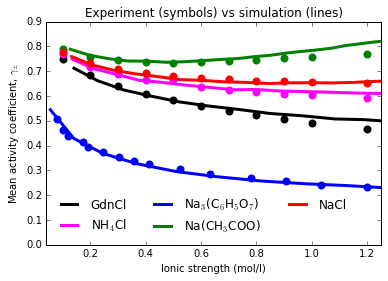

In [6]:
%cd -q $workdir
def ionicstrength(c, n1, n2, z1, z2):
    return 0.5*( n1*c*z1**2 + n2*c*z2**2 )

def meanactivity(gA, gB, p, q):
    ''' mean ionic activity coefficient '''
    return ( gA**p * gB**q ) ** (1.0/(p+q))

for salt, d in salts.iteritems():
    # experiment (already tabulated as ionic strength)
    I, g = np.loadtxt(d.exp, delimiter=',', skiprows=1, unpack=True)
    plt.plot(I, g, marker='o', ls='none', ms=8, mew=0, color=d.color)
    
    # simulation
    g = meanactivity( np.array(d.g1), np.array(d.g2), d.n1, d.n2 )
    C = d.activities / g # molarity
    I = ionicstrength(C, d.n1, d.n2, d.z1, d.z2)
    
    plt.plot( I, g, label=d.label, lw=3, color=d.color)

plt.legend(loc=0, frameon=False, ncol=3)
plt.ylabel('Mean activity coefficient, $\gamma_{\pm}$')
plt.xlabel('Ionic strength (mol/l)')
plt.xlim((0.04,1.25))
plt.ylim((0,0.9))
plt.title('Experiment (symbols) vs simulation (lines)')
print('')

### Pair potential between ions

The MC simulation uses a pair potential that is a mix of Lennard-Jones plus a Coulomb interaction with a high dielectric background. The particle radii are therefore _not_ just the normal interpretation as in LJ as is illustrated for the distance of closest approach between a cation and anion below.

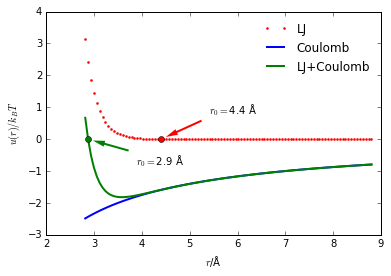

In [7]:
from scipy.optimize import newton

lB=7           # Bjerrum length for water (Å)
s=2*2.2        # sigma (Å)
eps=0.01 / 2.5 # epsilon (kT)
r = np.linspace(0.64*s, 2*s, 100)

def el(r): return -lB/r                        # Coulomb pot.
def lj(r): return 4*eps*( (s/r)**12-(s/r)**6 ) # Lennard-Jones pot.
def u(r): return lj(r) + el(r)                 # combined pot.

plt.plot(r, lj(r), 'r.', label='LJ', markersize=4 )
plt.plot(r, el(r), label='Coulomb', lw=2)
plt.plot(r, u(r), label='LJ+Coulomb', lw=2 )
plt.xlabel(u'$r$/Å')
plt.ylabel(u'$u(r)/k_BT$')
plt.legend(loc=0, frameon=False)

r0 = newton(u, x0=0.5*s) # when is u(r) zero?
plt.plot([r0], [0], 'go')
plt.annotate( '$r_0=$'+str('%.1f' % r0)+u' Å', xy=(r0, 0), xytext=(r0+1, -0.8),
             arrowprops=dict(facecolor='green', width=2, headwidth=6, edgecolor='none', shrink=0.1) )

plt.plot([s], [0], 'ro')
plt.annotate( '$r_0=$'+str('%.1f' % s)+u' Å', xy=(s, 0), xytext=(s+1, 0.8),
             arrowprops=dict(facecolor='red', width=2, headwidth=6, edgecolor='none', shrink=0.1) )

# II. pH Titration of a Single Macromolecule

We will now use the same model as before, but with a central, rigid molecule centered in the middle of the simulation box. Protons on acidic and basic residues fluctuate according to the specified pH and 1:1 salt is treated grand canonically.

In [8]:
def mkinput():
    global micro, d, xfc_freq, activity, macromolecule, pH
    js = {
            "moleculelist": {
                "_protein": { "structure":macromolecule, "Ninit":1, "insdir":"0 0 0" },
                "counter": { "Ninit": 8, "atomic": True, "atoms":"CNa" },
                "salt":    { "Ninit": 30, "atomic": True, "atoms": d.n1*(d.ion1+' ') + d.n2*(d.ion2+' ') }
            }, 
            "energy": {
                "nonbonded": { "coulomb": { "epsr": 80 } }
            }, 
            "moves": {
                "atomtranslate": {
                    "salt": { "peratom": True, "prob": 1.0 },
                    "counter": { "peratom": True, "prob": 1.0 }
                }
            },
            "system": {
                "mcloop"      : { "macro": 10, "micro": micro }, 
                "cuboid"      : { "len": d.L },
                "coulomb"     : { "epsr": 80 },
                "temperature" : 298.15
            }, 
            "atomlist": {
                d.ion1 :  { "q": d.z1, "r": d.r1, "eps":0.01, "dp": 50, "activity": d.n1*activity }, 
                d.ion2 :  { "q": d.z2, "r": d.r2, "eps":0.01, "dp": 50, "activity": d.n2*activity },
                "CNa"  :  { "q": d.z1, "r": d.r1, "eps":0.01, "dp": 50 },
                "ASP"  :  { "q":-1, "r":3.6, "mw":110, "eps":0.01 },
                "HASP" :  { "q":0,  "r":3.6, "mw":110, "eps":0.01 },
                "LASP" :  { "q":2,  "r":3.6, "mw":110, "eps":0.01 },
                "CTR"  :  { "q":-1, "r":2.0, "mw":16, "eps":0.01 },
                "HCTR" :  { "q":0,  "r":2.0, "mw":16, "eps":0.01 },
                "GLU"  :  { "q":-1, "r":3.8, "mw":122, "eps":0.01 },
                "HGLU" :  { "q":0,  "r":3.8, "mw":122, "eps":0.01 },
                "LGLU" :  { "q":2,  "r":3.8, "mw":122, "eps":0.01 },
                "HIS"  :  { "q":0,  "r":3.9, "mw":130, "eps":0.01 },
                "HHIS" :  { "q":1,  "r":3.9, "mw":130, "eps":0.01 },
                "NTR"  :  { "q":0,  "r":2.0, "mw":14, "eps":0.01 },
                "HNTR" :  { "q":1,  "r":2.0, "mw":14, "eps":0.01 },
                "TYR"  :  { "q":-1, "r":4.1, "mw":154, "eps":0.01 },
                "HTYR" :  { "q":0,  "r":4.1, "mw":154, "eps":0.01 },
                "LYS"  :  { "q":0,  "r":3.7, "mw":116, "eps":0.01 },
                "HLYS" :  { "q":1,  "r":3.7, "mw":116, "eps":0.01 },
                "CYb"  :  { "q":0,  "r":3.6, "mw":103, "eps":0.01 },
                "CYS"  :  { "q":-1, "r":3.6, "mw":103, "eps":0.01 },
                "HCYS" :  { "q":0,  "r":3.6, "mw":103, "eps":0.01 },
                "ARG"  :  { "q":0,  "r":4.0, "mw":144, "eps":0.01 },
                "HARG" :  { "q":1,  "r":4.0, "mw":144, "eps":0.01 },
                "ALA"  :  { "q":0,  "r":3.1, "mw":66, "eps":0.01 },
                "ILE"  :  { "q":0,  "r":3.6, "mw":102, "eps":0.01 },
                "LEU"  :  { "q":0,  "r":3.6, "mw":102, "eps":0.01 },
                "MET"  :  { "q":0,  "r":3.8, "mw":122, "eps":0.01 },
                "PHE"  :  { "q":0,  "r":3.9, "mw":138, "eps":0.01 },
                "PRO"  :  { "q":0,  "r":3.4, "mw":90, "eps":0.01 },
                "TRP"  :  { "q":0,  "r":4.3, "mw":176, "eps":0.01 },
                "VAL"  :  { "q":0,  "r":3.4, "mw":90, "eps":0.01 },
                "SER"  :  { "q":0,  "r":3.3, "mw":82, "eps":0.01 },
                "THR"  :  { "q":0,  "r":3.5, "mw":94, "eps":0.01 },
                "ASN"  :  { "q":0,  "r":3.6, "mw":108, "eps":0.01 },
                "GLN"  :  { "q":0,  "r":3.8, "mw":120, "eps":0.01 },
                "GLY"  :  { "q":0,  "r":2.9, "mw":54, "eps":0.01 }
            },
            "processes" : {
                "H-Asp" : { "bound":"HASP" , "free":"ASP" , "pKd":4.0  , "pX":pH },
                "H-Ctr" : { "bound":"HCTR" , "free":"CTR" , "pKd":2.6  , "pX":pH },
                "H-Glu" : { "bound":"HGLU" , "free":"GLU" , "pKd":4.4  , "pX":pH },
                "H-His" : { "bound":"HHIS" , "free":"HIS" , "pKd":6.3  , "pX":pH },
                "H-Arg" : { "bound":"HARG" , "free":"ARG" , "pKd":12.0 , "pX":pH },
                "H-Ntr" : { "bound":"HNTR" , "free":"NTR" , "pKd":7.5  , "pX":pH },
                "H-Cys" : { "bound":"HCYS" , "free":"CYS" , "pKd":10.8 , "pX":pH },
                "H-Tyr" : { "bound":"HTYR" , "free":"TYR" , "pKd":9.6  , "pX":pH },
                "H-Lys" : { "bound":"HLYS" , "free":"LYS" , "pKd":10.4 , "pX":pH }
            },
            "xtc_freq" : xtc_freq
    }
    
    if (TITRATION):
        js['moves']['gctit'] = { "molecule": "salt", "prob": 1.0 }
    if (GC):
        js['moves']['atomgc'] = { "molecule": "salt" }

    print('Writing JSON file')
    with open('excess.json', 'w+') as f:
        f.write(json.dumps(js, indent=4))
        
def WriteAAM( filename, aam ):
    f = open( filename,'w' )
    f.write( str(len(aam)) + '\n' )
    for i,j in aam.iterrows():
        f.write('{0:4} {1:5} {2:8.3f} {3:8.3f} {4:8.3f} {5:6.3f} {6:6.2f} {7:6.2f}\n'\
                .format(j['name'], i+1, j.x, j.y, j.z, j.q, j.mw, j.r))
    f.close()

def AverageChargeAAM(aamfile, gctit_output, group='_protein', scale2int=True):
    from math import floor
    ''' Save aam file w. average charges based on gctit-output (json file) '''
    aam = pd.read_table(aamfile, sep=' ', skiprows=1, usecols=[0,2,3,4,5,6,7], names=['name','x','y','z','q','mw','r'])

    js = json.load( open(gctit_output) ) [group]
    js = pd.DataFrame( js, index=js['index'] )

    f = 1.0
    if scale2int:
        total = js.charge.sum()
        target = round(total, 0)
        f = target / total
    
    aam.q = f*js.charge        # copy avg. charges of titratable sites
    aam.q = aam.q.fillna(0)  # fill missing
    
    print('net charge = ', aam.q.sum())
            
    return aam

### Run titration simulations at different pH

The proton titration routine allows only for 1:1 salts and undefined behavior is expected with 2:1 or 3:1 salts. Note that this is a current _technical_ limitation that could be eliminated in the future. After the simulation is done, a final structure with average charges is saved to disk.

Steps:

1. Loop over pH, single salt activity (NaCl)
2. Equilibration and production MC runs
3. Plot charge vs. pH

/Users/mikael/github/faunus-notebooks/activity-coefficients
net charge =  83.4829348575
net charge =  69.6038371848
net charge =  54.934195281
net charge =  37.6240777873
net charge =  24.4116131091
net charge =  13.4652225629
net charge =  6.09230600782
net charge =  0.740488828997
net charge =  -2.89651298856
net charge =  -5.84951257454
net charge =  -9.44671245421
net charge =  -12.1844587113
net charge =  -15.0530532078
net charge =  -17.9951466744
net charge =  -20.8132972004
net charge =  -25.3386946425
net charge =  -32.2316858912
net charge =  -40.2991586033
net charge =  -51.8417390239
net charge =  -64.0917993408
done.


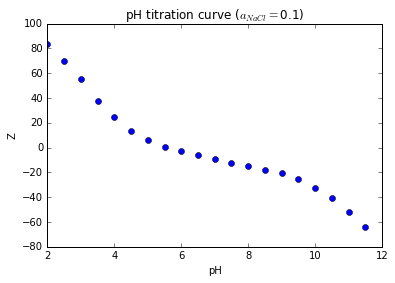

In [9]:
%cd $workdir
macromolecule = '../hsa-ph7.aam'
xtc_freq      = 1e200      # frequency to save xtc file (higher=less frames)
pH_range      = np.arange(2.0, 12.0, 0.5)
activity      = 0.1        # mol/l
d             = salts.NaCl # which salt
d.L           = 120        # box length (Å)
TITRATION     = True       # Do pH titration
GC            = False

tdata         = { 'pH': [], 'Z': [] } # store titration curve here

def getPrefix( pH, activity ):
    return 'titration-pH' + str(pH) + '-activity' + str(activity)

for pH in pH_range:
    pfx = getPrefix(pH, activity)
    if not os.path.isdir(pfx): # run simulation
        %mkdir -p $pfx 
        %cd -q $pfx

        # equilibration run (no translation)
        !rm -fR state
        micro=500
        mkinput()
        !../mc/excess > eq

        # production run
        micro=2000
        mkinput()
        !../mc/excess > out
        
        # create an aam file w. average charges
        aam = AverageChargeAAM( macromolecule, 'gctit-output.json', group='_protein', scale2int=True )
        WriteAAM( 'avgcharge.aam', aam )
        %cd -q ..
        
    if os.path.isdir(pfx): # analysis
        %cd -q $pfx
        aam = AverageChargeAAM( macromolecule, 'gctit-output.json', group='_protein', scale2int=False )
        tdata['pH'].append( pH )
        tdata['Z'].append( aam.q.sum() )
        %cd -q ..

if len( tdata['pH'] ) > 0:
    plt.plot(tdata['pH'], tdata['Z'], 'bo')
    plt.xlabel('pH')
    plt.ylabel('Z')
    plt.title(u'pH titration curve ($a_{NaCl}=$'+str(activity)+')')

print('done.')

TITRATION = False

## III. Ion Distributions around Macromolecules

From the previous step, we have protein structure files (`.aam`) at with fixed charges corresponding to specific pH. These can now be placed in the middle of the box, while salt (1:1, 2:1, 3:1) are treated with GCMC.

### Run simulation

In the equilibration run, Grand Canonical salt is enabled, meaning that the right amount of salt particles is being "sucked" into the simulation box according to the input activity / chemical potential.

Next, the final configuration from the equilibration is used as a starting point for a production run where the number of salt particles is fixed. This is because we now save configurations to an XTC trajectory (Gromacs style) that we will use for further analysis. This format does not support fluctuating number of particles.

To analyse the spatial distribution functions, i.e. generate `cube` files, Gromacs must be installed, in particular the `gmx` tool. **You may need to adjust** the numbers specified in the `echo` command just before `gmx`: these specify which groups to analyse and should point to `Na` and `Cl`, respectively (check gmx output).

Todo:

- Loop over structures from step II

In [10]:
import mdtraj as md

activity=0.1   # mol/l
d = salts.NaCl # which salt
d.L=120        # box length (Å)

eq=False
prod=False
analyse=True

# Generate Gromacs index.ndx file
f = open('index.ndx', 'w')
traj = md.load('confout.gro')
ndx_ion1 = traj.top.select('name '+d.ion1) # index w. all cations
ndx_ion2 = traj.top.select('name '+d.ion2) # index w. all anions
ndx_sys  = traj.top.select('all')
f.write( '[' + d.ion1 + ']\n' + ' '.join(str(e+1) for e in ndx_ion1 ) + 2*'\n')
f.write( '[' + d.ion2 + ']\n' + ' '.join(str(e+1) for e in ndx_ion2 ) + 2*'\n')
f.write( '[ System ]\n' + ' '.join(str(e+1) for e in ndx_sys ) + 2*'\n')
f.close()

if eq:
    print('Equilibration run - GC enabled')
    GC=True
    xtc_freq=1e10
    micro=100
    mkinput()
    !rm -fR state
    !mc/excess > eq

if prod:
    print('Production run - GC disabled')
    GC=False
    xtc_freq=10
    micro=10000
    mkinput()
    !mc/excess > out
    
if analyse:
    !cp confout.pqr confout.pdb # dirty conversion, but will work for this purpose
    !echo -ne "$d.ion1\nSystem" | gmx --quiet --nobackup spatial -s confout.gro -f traj.xtc -bin 0.2 -nopbc -n index.ndx   # Sodium
    !mv grid.cube ion1.cube
    !echo -ne "$d.ion2\nSystem" | gmx --quiet --nobackup spatial -s confout.gro -f traj.xtc -bin 0.2 -nopbc -n index.ndx   # Chloride
    !mv grid.cube ion2.cube
    !rm confout.pdb


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Select group to generate SDF:
Group     0 (             Na) has   114 elements
Group     1 (             Cl) has   114 elements
Group     2 (         System) has   819 elements
Select a group: Error: No such group '_NE'
Select a group: Selected 0: 'Na'
Select group to output coords (e.g. solute):
Group     0 (             Na) has   114 elements
Group     1 (             Cl) has   114 elements
Group     2 (         System) has   819 elements
Select a group: Selected 2: 'System'
Reading frame    9000 time 9000.000   
Counts per frame in all 250047 cubes divided by 4.559143e-04
Normalized data: average 1.000000e+00, min 0.000000e+00, max 1.645046e+01

         based on residue and atom names, since they

### Viewing

To view the density maps, open the above generated files with:

`vmd confout.pqr ion1.cube ion2.cube confout.pqr`

(In my version of VMD, `confout.pqr` has to be specified twice to respect radii and charges when cube files are loaded)

- Go to `representation`
- Use _vdW_ for the selection: `not name Na Cl CNa`
- Use _iso-density_ representation for the two density maps, and adjust threshold. Chose _solid surface_.

#### Unfinished stuff

In [11]:
import load_cube
# create an object and read in data from file 
cube=load_cube.CUBE('ion1.cube')
# calculate total number of data points
print("Number of voxels: ", cube.NX*cube.NY*cube.NZ)
# calculate box volume
#print("Total volume, Angs^3: %d"%((cube.NX-1)*cube.X[0]*(cube.NY-1)*cube.Y[1]*(cube.NZ-1)*cube.Z[2])
# calculate total electron density by summing up squared values, contained in 3d array cube.data 
#print("Number of electrons (sort of): %.2f"%((cube.data**2).sum()*cube.X[0]*cube.Y[1]*cube.Z[2])


/Users/mikael/github/faunus-notebooks/activity-coefficients/load_cube.py:32: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.data[i/(self.NY*self.NZ), (i/self.NZ)%self.NY, i%self.NZ] = float(v)


Number of voxels:  250047
